# PROJET NLP 

In [ ]:
from pathlib import Path
import numpy as np
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, FastText as gs_FastText
import re
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import set_config
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             roc_auc_score,
                             confusion_matrix,
                            )
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold

set_config(display="diagram", print_changed_only=False)
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

data = pd.read_csv("UpdatedResumeDataSet.csv", encoding="utf-8")
data.head()

Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...

In [3]:
data["Category"].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [4]:
label_distribution = data[["Category"]].value_counts()
label_distribution

Category                 
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Data Science                 40
Operations Manager           40
Sales                        40
Blockchain                   40
ETL Developer                40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: count, dtype: int64

In [5]:
data.shape

(962, 2)

<Axes: xlabel='Category'>

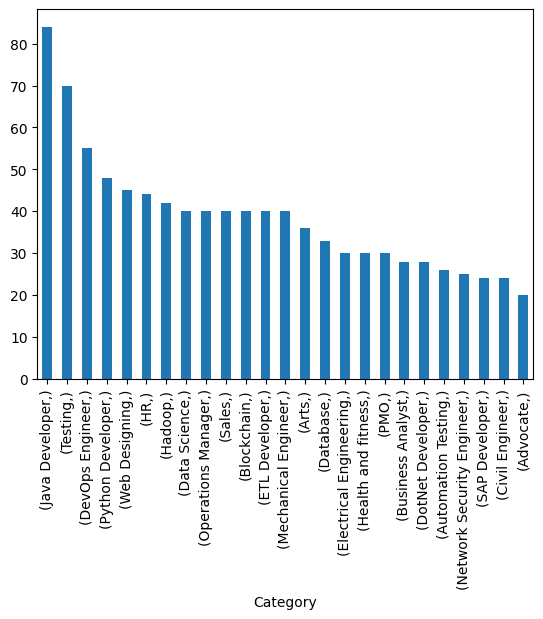

In [6]:
label_distribution.plot(kind="bar")

In [7]:
all_text = " ".join(data.Resume.str.lower())
words_frequency = Counter(all_text.split())
all_text
words_frequency

Counter({'and': 16680,
         'â\x80¢': 12213,
         'the': 11442,
         '-': 10929,
         'of': 8759,
         'to': 7588,
         'in': 5514,
         'for': 5235,
         'exprience': 3829,
         'with': 3797,
         '&': 3650,
         'company': 3336,
         'months': 3182,
         'details': 3051,
         'project': 2989,
         'description': 2692,
         'on': 2673,
         'a': 2351,
         'as': 2295,
         'data': 1940,
         'is': 1585,
         'team': 1582,
         'management': 1414,
         '1': 1402,
         'maharashtra': 1356,
         'year': 1272,
         'from': 1263,
         '6': 1246,
         'all': 1226,
         'than': 1182,
         'by': 1151,
         'less': 1145,
         'business': 1119,
         'using': 1116,
         'january': 1090,
         'skill': 1080,
         'system': 990,
         'testing': 989,
         'test': 980,
         'engineering': 973,
         'developer': 959,
         'database': 938,
 

In [8]:
words_frequency.most_common(n=30)

[('and', 16680),
 ('â\x80¢', 12213),
 ('the', 11442),
 ('-', 10929),
 ('of', 8759),
 ('to', 7588),
 ('in', 5514),
 ('for', 5235),
 ('exprience', 3829),
 ('with', 3797),
 ('&', 3650),
 ('company', 3336),
 ('months', 3182),
 ('details', 3051),
 ('project', 2989),
 ('description', 2692),
 ('on', 2673),
 ('a', 2351),
 ('as', 2295),
 ('data', 1940),
 ('is', 1585),
 ('team', 1582),
 ('management', 1414),
 ('1', 1402),
 ('maharashtra', 1356),
 ('year', 1272),
 ('from', 1263),
 ('6', 1246),
 ('all', 1226),
 ('than', 1182)]

In [ ]:
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kosso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# get list of stopwords
stopwords_nltk = set(stopwords.words('english'))

def display_wordcloud(corpus, title=""):
    plt.figure(figsize=(10, 5))
    wc = WordCloud(background_color="white",
                   max_words=1000,
                   colormap='hsv',
                   #stopwords=stopwords_nltk,
                   collocations=False)
    # generate word cloud
    # wc.generate_from_frequencies(words_frequency)
    wc.generate_from_text(corpus)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis("off");


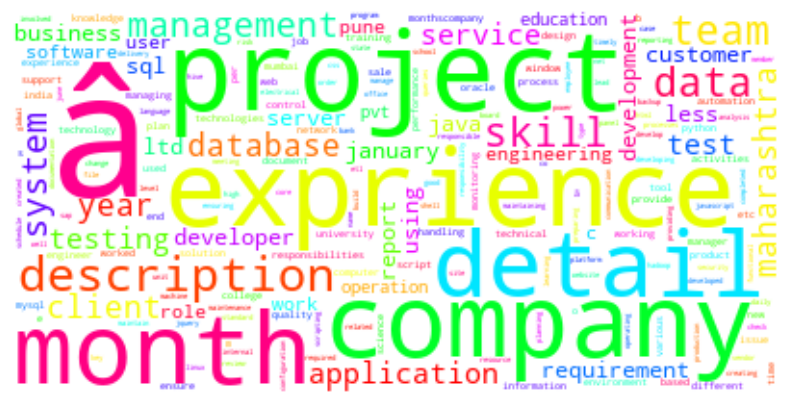

In [11]:
display_wordcloud(corpus=all_text)

Empty DataFrame
Columns: []
Index: []

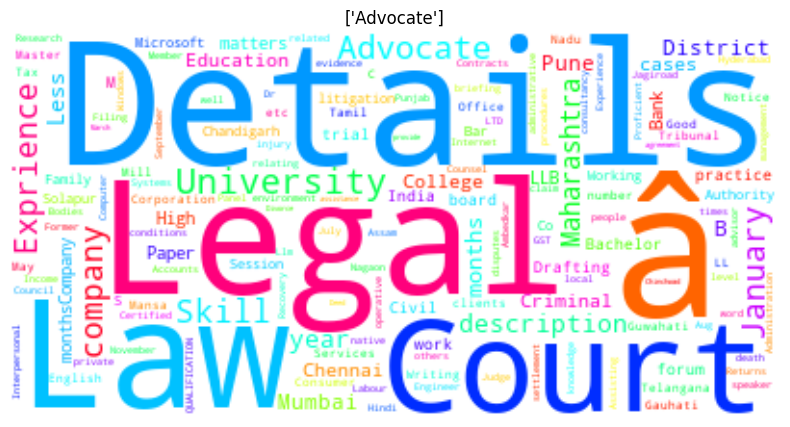

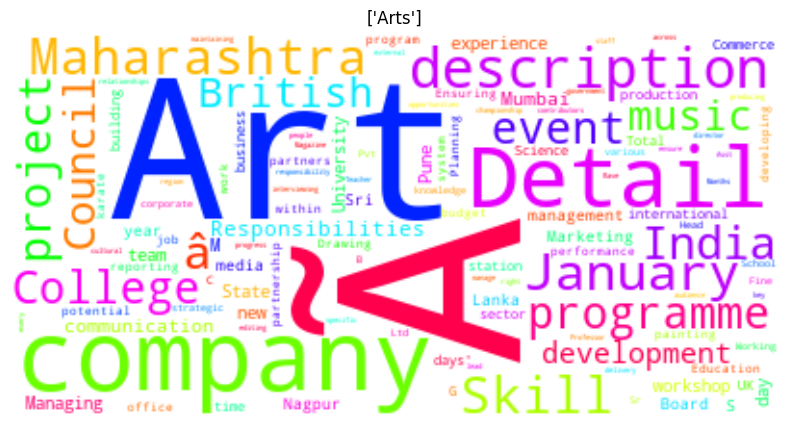

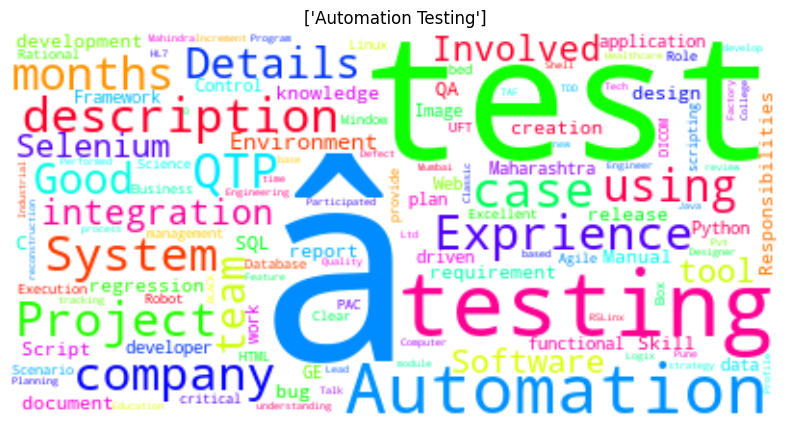

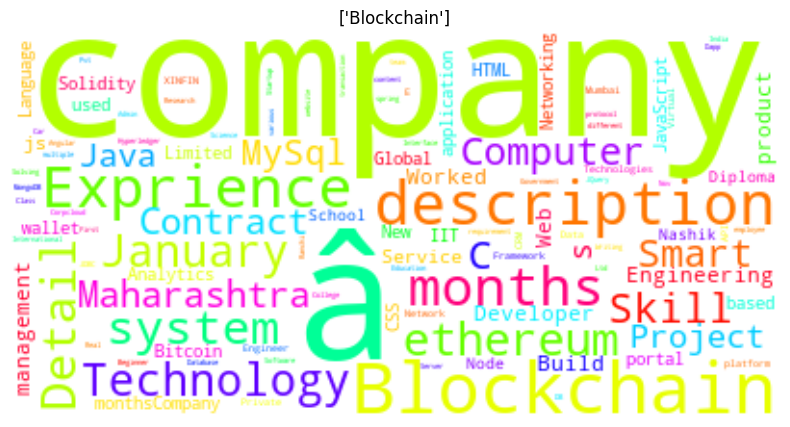

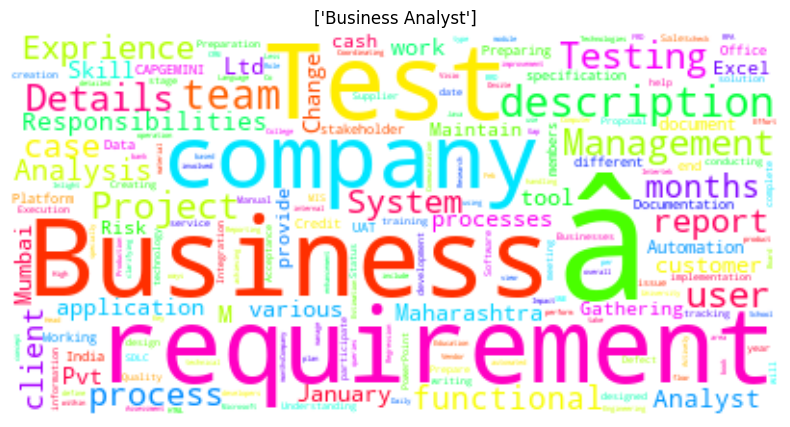

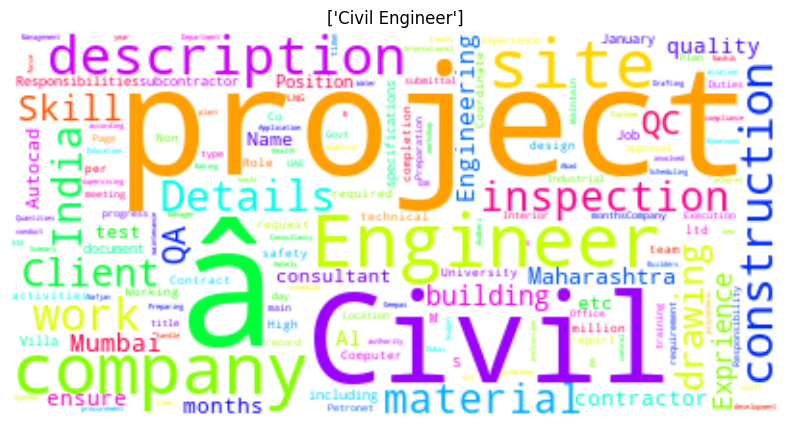

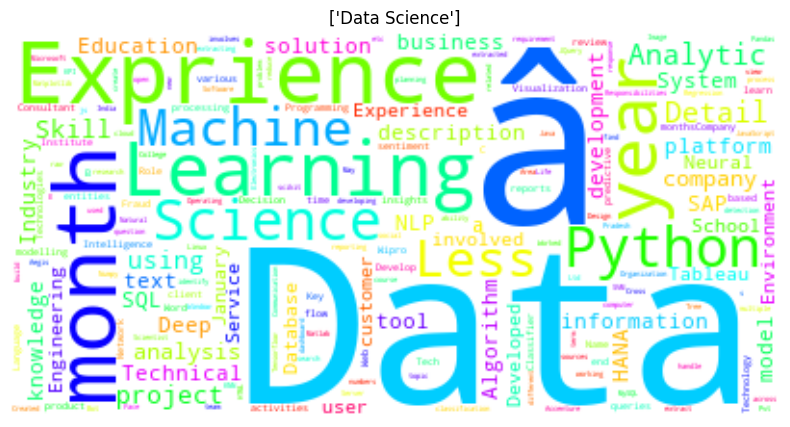

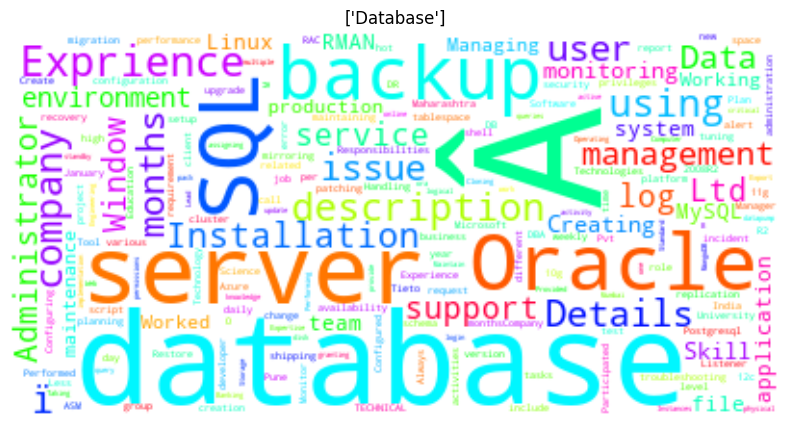

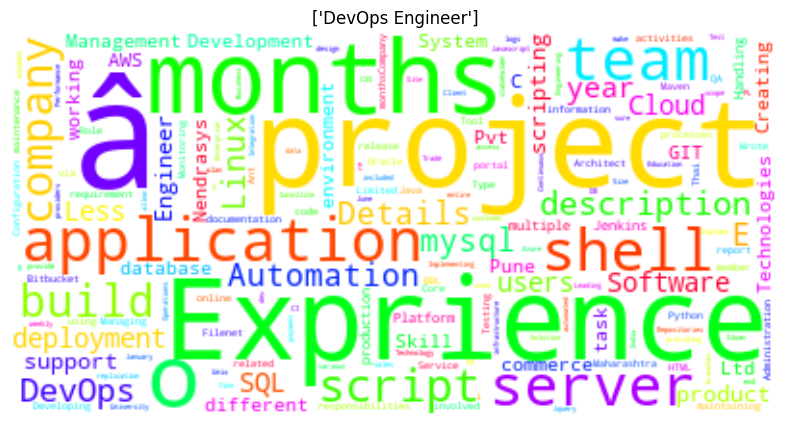

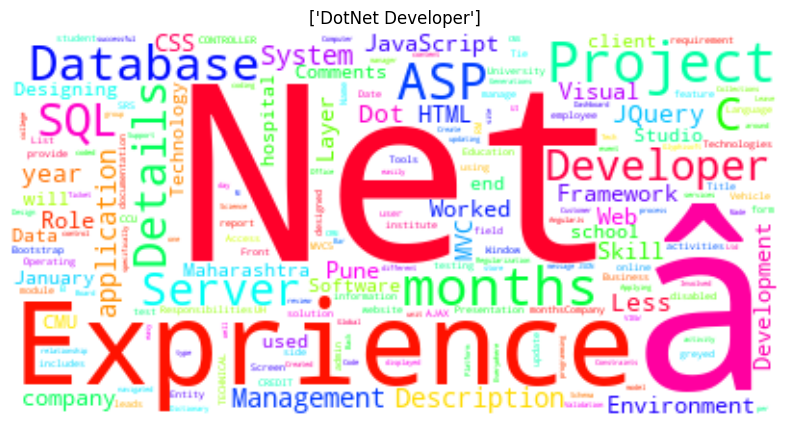

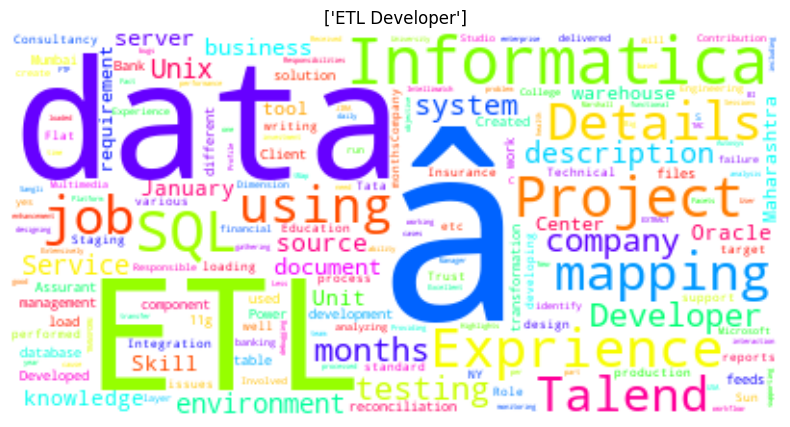

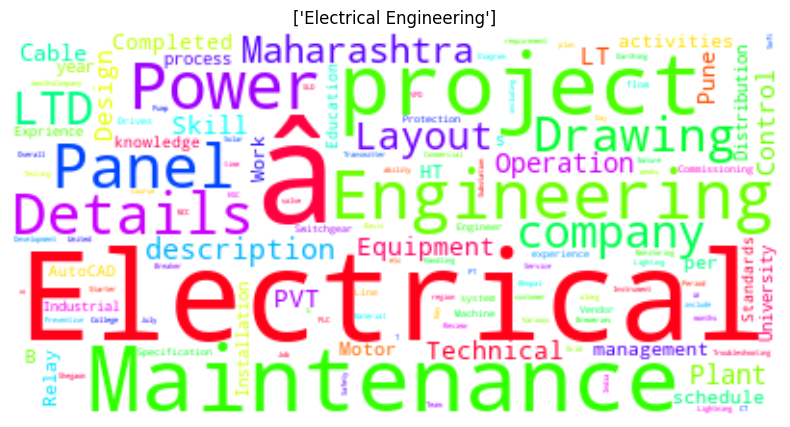

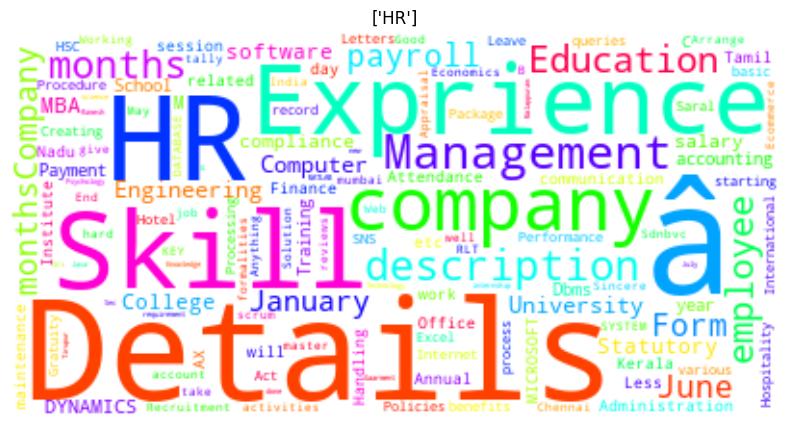

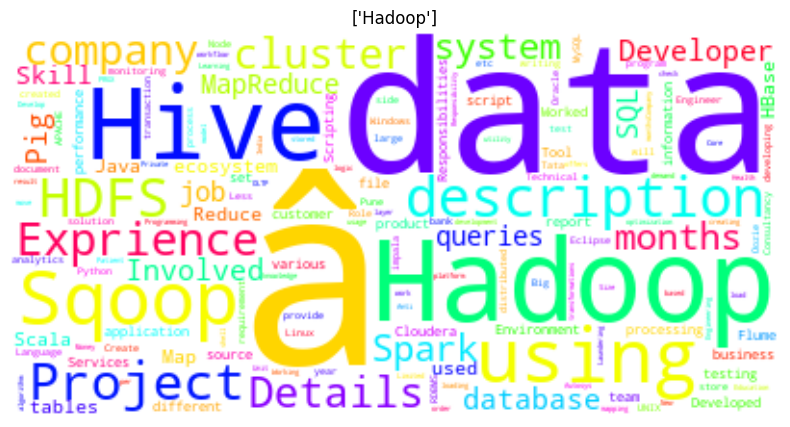

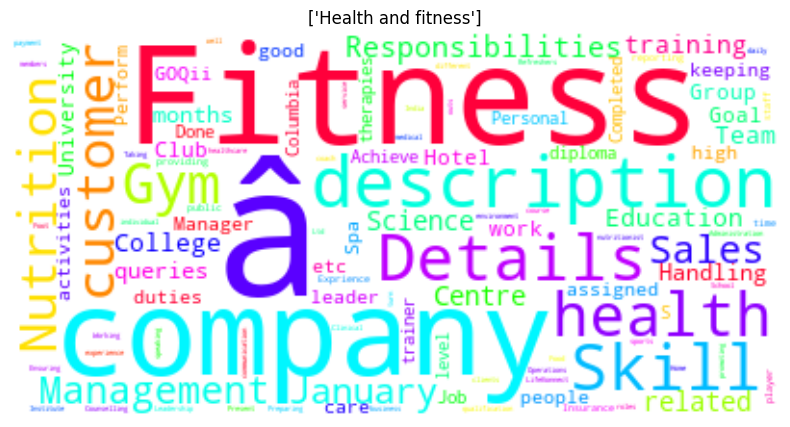

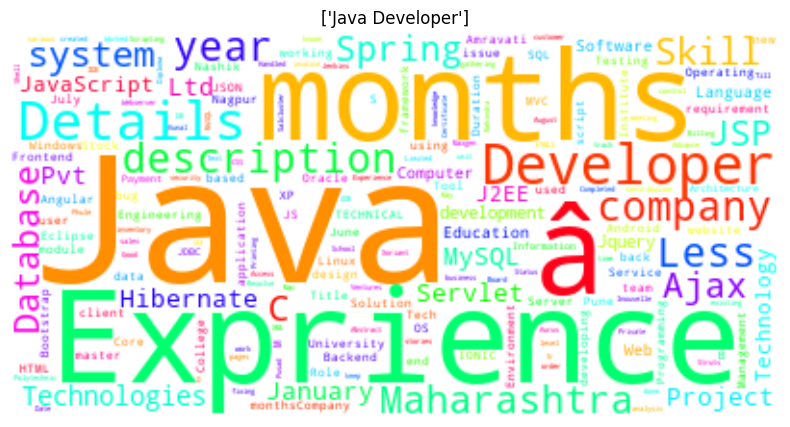

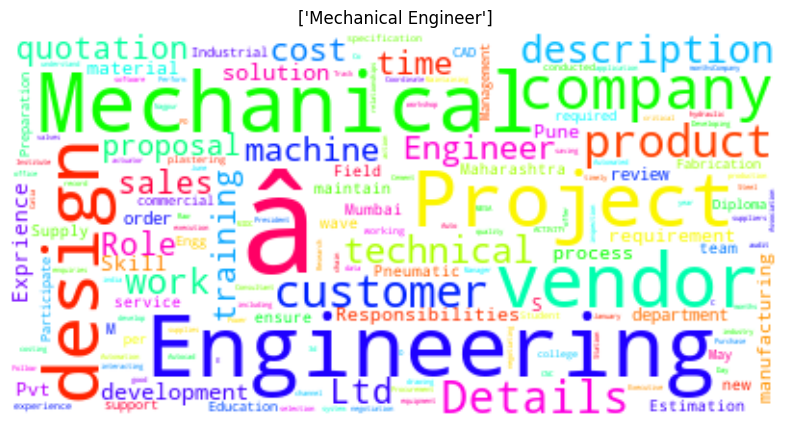

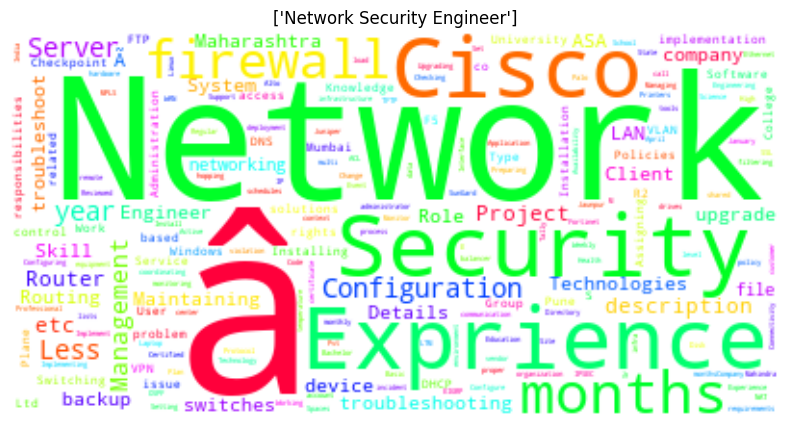

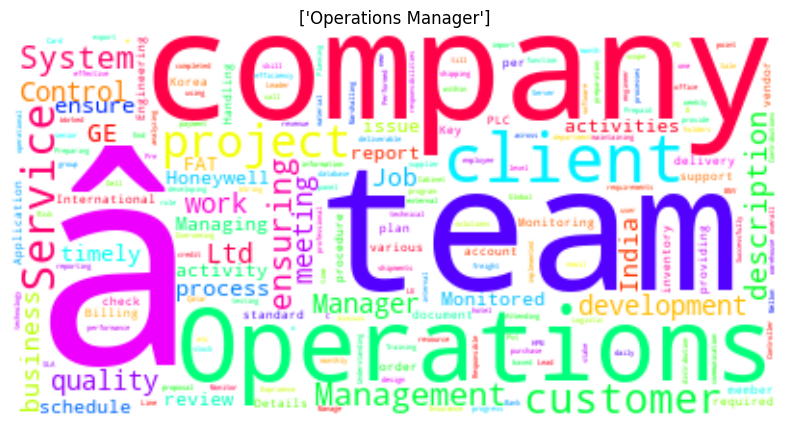

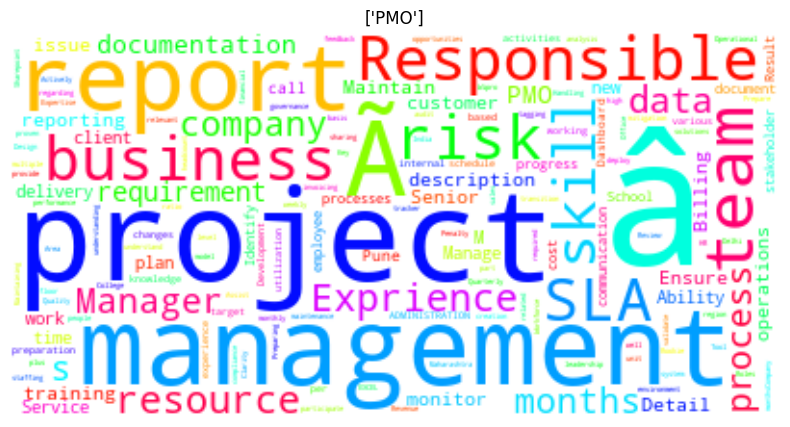

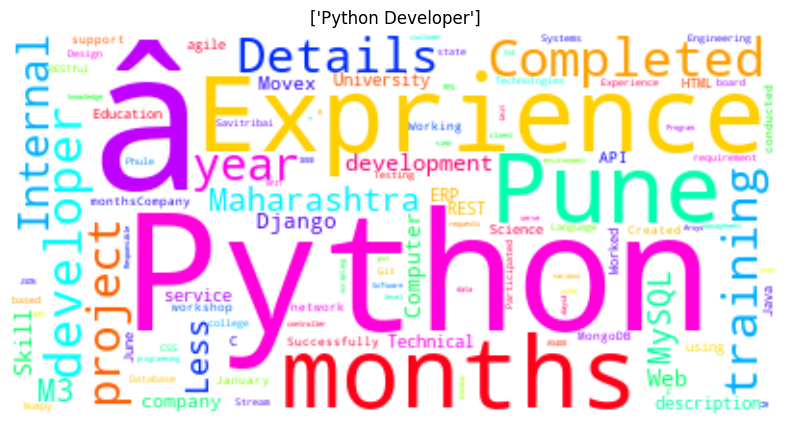

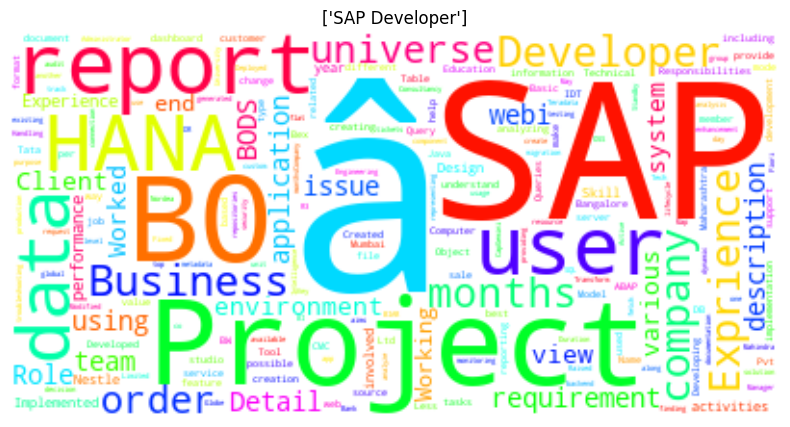

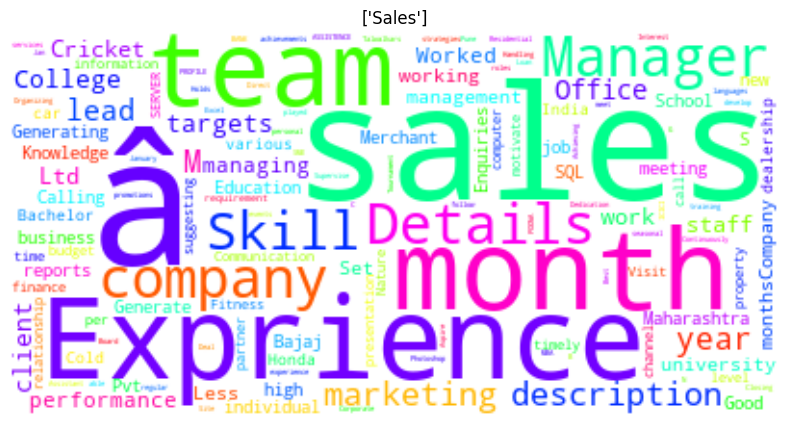

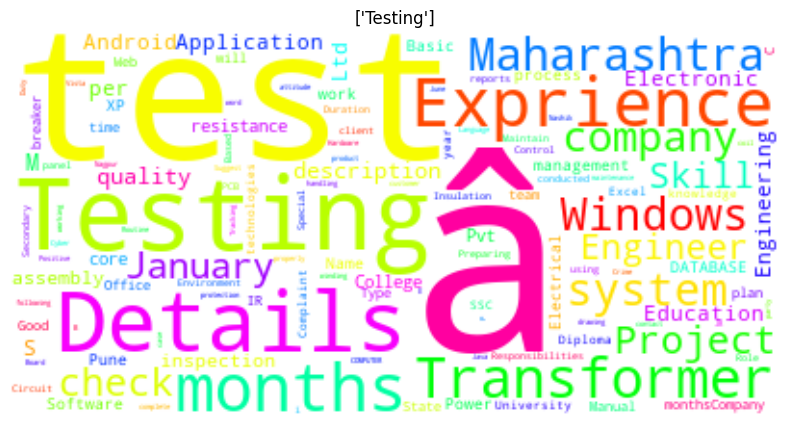

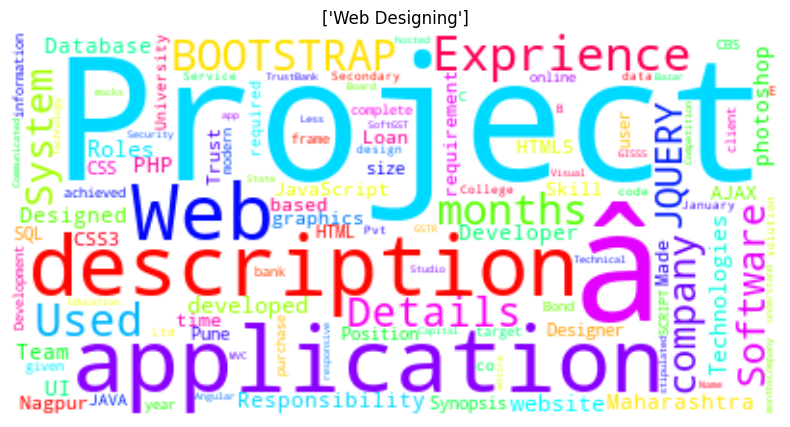

In [12]:
data.groupby("Category").apply(
    lambda group: display_wordcloud(" ".join(group.Resume), title=group.Category.unique()))

In [13]:
def preprocess_text(text, language="english", stopwords=None, normalizer="stem"):
    
    valid_normalizer = (None, "stem", "lemma")
    if not normalizer in valid_normalizer:
        raise ValueError(f"`normalizer` must be in `{valid_normalizer}`")
    # lower case
    text = text.lower()
    
    # delete html balise
    # We can also use BeautifulSoup package to get the text from HTML document
    # re = regular expression
    text = re.sub(re.compile('<.*?>'), '', text)
    
    # remove url
    text = re.sub(r'(http|www)\S*', '', text)

    # delete email
    text = re.sub(r"\S*@\S*\s*", "", text)
    
    # delete special character
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # delete number
    text = re.sub(r'[0-9]+','', text).strip() #strip permet d'enlever les espaces en début et fin de phrase
    
    # tokenizer 
    text_tokens = word_tokenize(text)
    
    # remove stopword
    if isinstance(stopwords, (set, list, tuple)):
        # split sentence
        text_tokens = [word for word in text_tokens if word not in stopwords]
    # stem string: snowball stemmer
    if normalizer == "stem":
        stemmer = SnowballStemmer(language, ignore_stopwords=True)
        text_tokens = [stemmer.stem(wrd) for wrd in text_tokens]
    elif normalizer == "lemma":
        lemmatizer = WordNetLemmatizer()
        text_tokens = [lemmatizer.lemmatize(wrd) for wrd in text_tokens]
         
    return " ".join(text_tokens)

In [14]:
%%time
# add new column for sanitizing
data["text_sanitize"] = data.Resume.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="stem")
data = data.assign(text_sanitize=lambda dfr : dfr.Resume.apply(preprocess_text, stopwords=stopwords_nltk, normalizer=None),
        text_sanitize_stem = lambda dfr : dfr.Resume.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="stem"),
        text_sanitize_lemm = lambda dfr : dfr.Resume.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="lemma")
)

CPU times: total: 27.6 s
Wall time: 35.6 s


In [15]:
data.head()

Category                                             Resume  \
0  Data Science  Skills * Programming Languages: Python (pandas...   
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...   
2  Data Science  Areas of Interest Deep Learning, Control Syste...   
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...   

                                       text_sanitize  \
0  skills programming languages python pandas num...   
1  education details may may b e uit rgpv data sc...   
2  areas interest deep learning control system de...   
3  skills â r â python â sap hana â tableau â sap...   
4  education details mca ymcaust faridabad haryan...   

                                  text_sanitize_stem  \
0  skill program languag python panda numpi scipi...   
1  educ detail may may b e uit rgpv data scientis...   
2  area interest deep learn control system design...   
3  skill â r â python â sap hana â tableau â sap ...   
4  educ detail mca ymcaust faridabad haryana data...   

                                  text_sanitize_lemm  
0  skill programming language python panda numpy ...  
1  education detail may may b e uit rgpv data sci...  
2  area interest deep learning control system des...  
3  skill â r â python â sap hana â tableau â sap ...  
4  education detail mca ymcaust faridabad haryana...

In [16]:
from sklearn.model_selection import train_test_split
# Séparation des features (X) et de la target (y)
X = data['text_sanitize']  # ou la colonne contenant votre texte nettoyé
y = data['Category']       # votre variable cible

# Séparation en train/test (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(
    X,                      # Features (texte)
    y,                      # Target (catégories)
    test_size=0.2,          # 20% pour le test
    random_state=42         # Reproductibilité
)

In [17]:
mnb_clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB()),  
])
mnb_clf_pipe

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True,
                               force_alpha=True))],
         transform_input=None, verbose=False)

In [18]:
mnb_clf_pipe.fit(X_train, y_train)
predicted_mnb = mnb_clf_pipe.predict(X_test)

<Axes: >

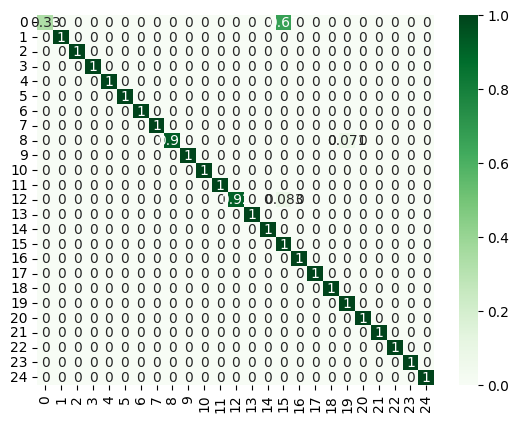

In [19]:
sns.heatmap(confusion_matrix(y_test, predicted_mnb, normalize="true"),
           annot=True, fmt='.2g', cmap="Greens")

In [20]:
print(classification_report( predicted_mnb,y_test))

                           precision    recall  f1-score   support

                 Advocate       0.33      1.00      0.50         1
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       0.93      1.00      0.96        13
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       0.92      1.00      0.96        11
                   Hadoop       1.00      1.00      1.00     

In [21]:
import pickle

# Sauvegarder le pipeline
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(mnb_clf_pipe, file)


In [22]:
params = {
    "vectorizer__max_df": [0.8, 1],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    'classifier__fit_prior': [True, False]
}

grid_search = GridSearchCV(mnb_clf_pipe, params, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# prediction
predicted_mnb_opt = grid_search.predict(X_test)

# Meilleurs paramètres
grid_search.best_params_

{'classifier__fit_prior': False,
 'vectorizer__max_df': 0.8,
 'vectorizer__norm': 'l2',
 'vectorizer__use_idf': True}

In [23]:
print(classification_report(predicted_mnb_opt,y_test))

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       0.93      1.00      0.96        13
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00        12
                   Hadoop       1.00      1.00      1.00     

In [24]:
import joblib

# Sauvegarder le meilleur modèle (par exemple LogisticRegression)
#joblib.dump(grid_search, 'nlp_classifier.pkl')

# Random forest

In [25]:
rf_clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier()),
])
rf_clf_pipe

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        monotonic_cst=None, n_estimators=100,
                                        n_jobs=None, oob_score=False,
                                        random_state=None, verbose=0,
                                        warm_start=False))],
         transform_input=None, verbose=False)

In [26]:
rf_clf_pipe.fit(X_train,y_train)
rf_predicted = rf_clf_pipe.predict(X_test)

In [27]:
print(classification_report(y_test, rf_predicted))

                           precision    recall  f1-score   support

                 Advocate       1.00      0.33      0.50         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       0.86      1.00      0.92        12
                   Hadoop       1.00      1.00      1.00     

In [28]:
LR_clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf_LR', LogisticRegression(random_state=42))
])
LR_clf_pipe

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf_LR',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='deprecated', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         transform_input=None, verbose=False)

In [29]:
LR_clf_pipe.fit(X_train, y_train)
LR_predicted = LR_clf_pipe.predict(X_test)

In [30]:
print(classification_report(y_test, LR_predicted))

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00        12
                   Hadoop       1.00      1.00      1.00     

In [31]:
categories = []
for i in data.Category.unique():
    categories.append(i)

categories

['Data Science',
 'HR',
 'Advocate',
 'Arts',
 'Web Designing',
 'Mechanical Engineer',
 'Sales',
 'Health and fitness',
 'Civil Engineer',
 'Java Developer',
 'Business Analyst',
 'SAP Developer',
 'Automation Testing',
 'Electrical Engineering',
 'Operations Manager',
 'Python Developer',
 'DevOps Engineer',
 'Network Security Engineer',
 'PMO',
 'Database',
 'Hadoop',
 'ETL Developer',
 'DotNet Developer',
 'Blockchain',
 'Testing']

In [32]:
data["Resume"][0]

'Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details \r\n\r\nData Science Assurance Associate \r\n\r\nData Science Assurance Associate - Ernst & Young LLP\r\nSkill Details \r\nJAVASCRIPT- Exprience - 24 months\r\njQuery- Exprience - 24 months\r\nPython- Exprience - 24 monthsCompany Details \r\ncompany - Ernst & Young LLP\r\ndescription - Fraud Investigatio